In [1]:
import pandas as pd

In [2]:
ecapa_results = '../data/lid-vox-lingua107-ecapa-results'

In [10]:
df = pd.read_csv(ecapa_results+'.csv')
df.head()

,label,pred,pred_score,eng_score,acc
0,tic,sl,0.2963,0.0002,1
1,tic,no,0.2148,0.0166,1
2,tic,sw,0.2069,0.0011,1
3,tic,so,0.3580,0.0045,1
4,tic,sl,0.3263,0.0001,1


In [15]:
tic = df['label']=='tic'
eng = df['label']=='eng'

<Axes: title={'center': 'eng_score'}, xlabel='label'>

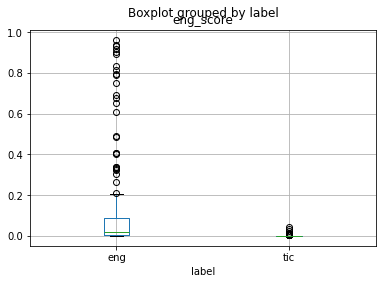

In [14]:
df.boxplot('eng_score', by='label')

In [18]:
eng_thresh = df.loc[tic, 'eng_score'].max()
eng_thresh

0.0433

In [24]:
eng_thresh = 0.01

In [25]:
above_thresh = df['eng_score'] > eng_thresh
df.loc[above_thresh, 'label'].value_counts()

eng    131
tic      7
Name: label, dtype: int64

In [26]:
df.loc[~above_thresh, 'label'].value_counts()

tic    193
eng     69
Name: label, dtype: int64

In [3]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from matplotlib import pyplot as plt
import pandas as pd

In [4]:
df = pd.read_csv('../data/lid-vox-lingua107-ecapa-embeds-3cat.csv')
df.head()

,Unnamed: 0,lang,audio
0,0,HIM,Audacity Recording 181[1535200.0-1537500.0].wav
1,1,HIM,Audacity Recording 181[1547800.0-1550000.0].wav
2,2,HIM,Audacity Recording 181[1562655.0-1565685.0].wav
3,3,HIM,Audacity Recording 181[1578900.0-1580300.0].wav
4,4,HIM,Audacity Recording 181[1580600.0-1582500.0].wav


In [5]:
tic = df['lang']=='TIC'
eng = df['lang']=='ENG'
him = df['lang']=='HIM'
df['y']=0
df.loc[tic,'y']=1
df['y'].value_counts()

0    400
1    200
Name: y, dtype: int64

In [6]:
df['y1']=df['y']
df.loc[him, 'y1']=2
df['y1'].value_counts()

2    200
0    200
1    200
Name: y1, dtype: int64

In [7]:
embeds = torch.load('../data/lid-vox-lingua107-ecapa-embeds-3cat.pt', map_location=torch.device('cpu'))
embeds = embeds.squeeze()
embeds.shape

torch.Size([600, 256])

In [8]:
logits, hs = torch.load('../data/mms-lid-126-embed.pt', map_location=torch.device('cpu'))
logits.shape, len(hs)

(torch.Size([600, 126]), 38)

In [16]:
hs_unsqueezed = []
for batch in hs:
    hs_unsqueezed+=batch
len(hs_unsqueezed)

600

In [17]:
hs = hs_unsqueezed

In [53]:
hs_means_by_layer = []
num_layers = len(hs[0])
for layer_idx in range(num_layers):
    layer_means = [
        torch.mean(ex[layer_idx], 0) for ex in hs
    ]
    hs_means_by_layer.append(torch.stack(layer_means))
hs_means_by_layer[0].shape

torch.Size([600, 1280])

In [59]:
pca = PCA(n_components=2)
pca

PCA(n_components=2)

In [60]:
pca_embeds = pca.fit_transform(embeds)
pca_embeds

array([[  10.20631384,  -91.79226152],
       [  -4.92665541,  -78.0248183 ],
       [ -11.70571516,  -68.89355753],
       ...,
       [ -45.29064516,  -93.24683871],
       [-109.37196049,   20.75016816],
       [ -71.11961724,  -51.98441365]])

In [62]:
pca_logits = pca.fit_transform(logits)
pca_logits

array([[ 9.07738449, -7.85256978],
       [-1.84973964, -8.54190023],
       [-3.57622623, -5.65473779],
       ...,
       [ 6.23053076,  5.66389456],
       [14.11748685,  6.20166631],
       [13.24897975, -6.01171397]])

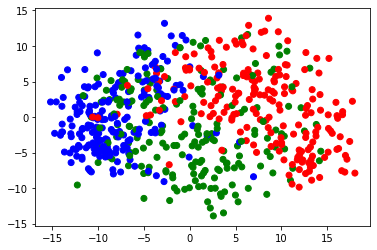

In [63]:
df['color'] = 'blue'
df.loc[df['lang']=='TIC','color'] = 'red'
df.loc[df['lang']=='HIM','color'] = 'green'

# x = pca_embeds[:,0]
# y = pca_embeds[:,1]
x = pca_logits[:,0]
y = pca_logits[:,1]
c = df['color']
plt.scatter(x, y, c=c)

In [56]:
kmeans = KMeans(2)
kmeans

KMeans(n_clusters=2)

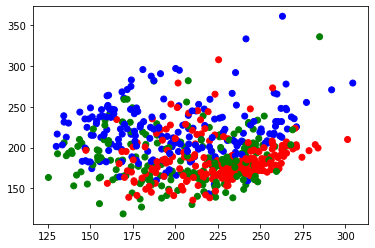

In [64]:
embeds_kmeans = kmeans.fit_transform(embeds)
x = embeds_kmeans[:,0]
y = embeds_kmeans[:,1]
plt.scatter(x, y, c=c)

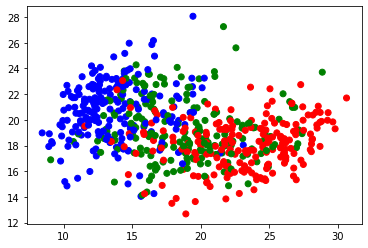

In [65]:
logits_kmeans = kmeans.fit_transform(logits)
x = logits_kmeans[:,0]
y = logits_kmeans[:,1]
plt.scatter(x, y, c=c)

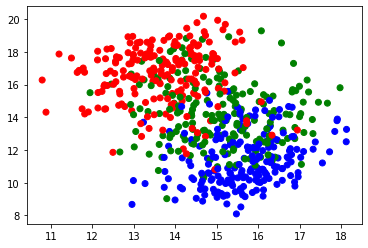

In [66]:
final_hs_kmeans = kmeans.fit_transform(final_hs_means)
x = final_hs_kmeans[:,0]
y = final_hs_kmeans[:,1]
plt.scatter(x, y, c=c)

In [42]:
lr = LogisticRegression()
lr

LogisticRegression()

In [99]:
x_train, x_test, y_train, y_test = train_test_split(logits,df['y'], test_size=0.1)

In [107]:
x_train, x_test, y_train, y_test = train_test_split(embeds,df['y'], test_size=0.5)

In [144]:
def eval_kmeans(x, y, n_clusters=2):
    labels = KMeans(n_clusters=n_clusters).fit(x).labels_
    return accuracy_score(y, labels)
eval_kmeans(embeds,df['y1'],3)

0.41333333333333333

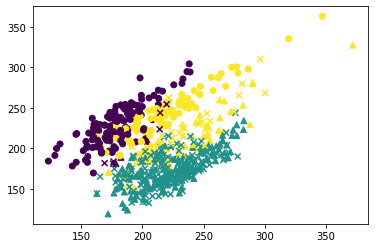

In [158]:
def plot_kmeans(x, y, n_clusters=2):
    clusters = KMeans(n_clusters=n_clusters).fit(x)
    labels = clusters.labels_
    points=clusters.transform(x)
    dim1=points[:,0]
    dim2=points[:,1]

    markers = ["^" , "o", "x"]
    for i, val in enumerate(y.unique()):
        slice=y==val
        plt.scatter(x=dim1[slice], y=dim2[slice], c=labels[slice], marker=markers[i])
plot_kmeans(embeds,df['y1'],3)

In [108]:
lr=lr.fit(x_train, y_train)
lr

LogisticRegression()

In [109]:
y_hat=lr.predict(x_test)
y_hat

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [110]:
accuracy_score(y_test, y_hat)

0.9566666666666667